<a href="https://colab.research.google.com/github/moeed17/AudioSignal_Perturbation_Analysis/blob/main/RF%20%26%20Shap_on_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import librosa

import scipy
from scipy.fft import fft, fftfreq

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#!pip install shap
import shap

In [17]:
#cloning the repository to import audio samples
!git clone https://github.com/moeed17/AudioSignal_Perturbation_Analysis.git

fatal: destination path 'AudioSignal_Perturbation_Analysis' already exists and is not an empty directory.


In [18]:
#setting the style of background for audio signal
plt.style.use('seaborn-v0_8-dark')

In [19]:
#importing clean audio
clean_audio_data = '/content/AudioSignal_Perturbation_Analysis/20db_clean.wav'
Clean_Data,sr = librosa.load(clean_audio_data, sr=None)

print("Sampling rate of clean audio is:",sr,"Hz.")

#importing perturbed audio
perturbed_audio_data = '/content/AudioSignal_Perturbation_Analysis/20db_perturbed.wav'
Perturbed_Data,srPert = librosa.load(perturbed_audio_data, sr=None)
print("Sampling rate of perturbed audio is:",srPert,"Hz.")

Sampling rate of clean audio is: 16000 Hz.
Sampling rate of perturbed audio is: 16000 Hz.


In [20]:
list_stft = []
list_Pertstft = []
list_zc = []

n_fft = 512 ; hop_length = 160; win_length = 480;  window = 'hann'
# sample rate is 16k meaning 16k samples in 1 sec
# 1sec == 16k samples -> 10 ms == 160 samples hence the hop length is 10 ms
# 30ms window length -> 10 ms == 160 samples so 3x that is 30ms == 480 samples

CleanSTFT = librosa.stft(Clean_Data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
CleanSTFT = abs(CleanSTFT)
Clean_Data_db = librosa.amplitude_to_db(CleanSTFT)

PerturbedSTFT = librosa.stft(Perturbed_Data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window)
Pert_STFT=abs(PerturbedSTFT)
Perturbed_Data_db = librosa.amplitude_to_db(Pert_STFT)

clean_zc = librosa.zero_crossings(Clean_Data, pad=False)
print("Zero Crossings before perturbation = " , sum(clean_zc))

pert_zc = librosa.zero_crossings(Perturbed_Data, pad=False)
print("Zero Crossings after perturbation = " , sum(pert_zc))

Zero Crossings before perturbation =  5022
Zero Crossings after perturbation =  15472


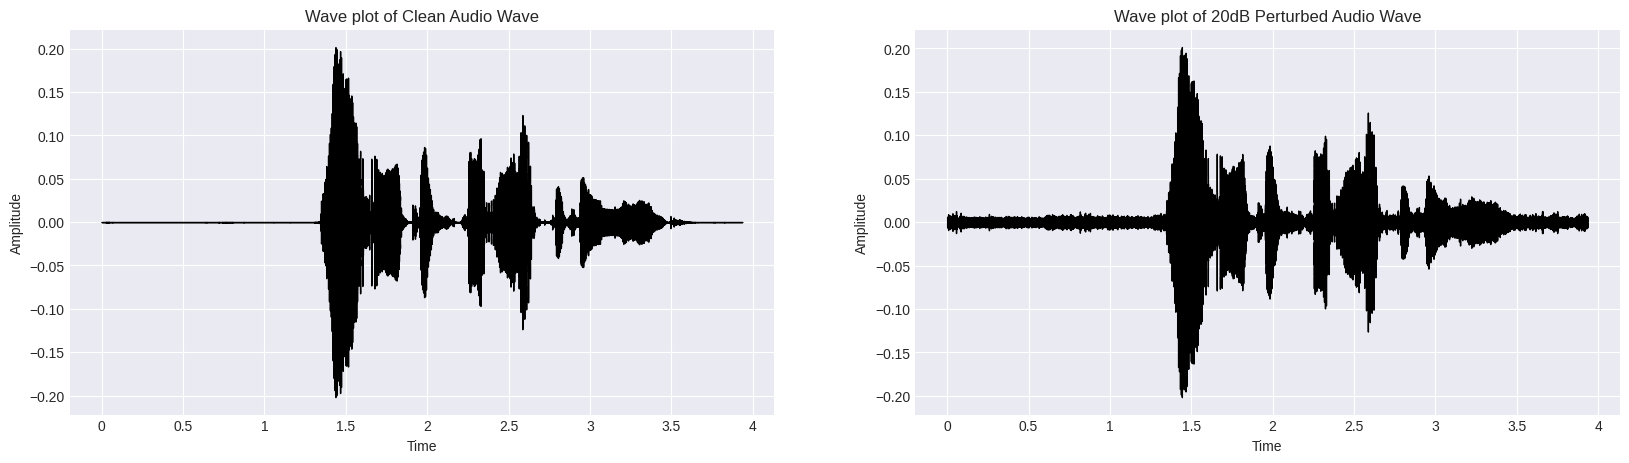

In [21]:
fig, ax =  plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20,5))

librosa.display.waveshow(Clean_Data, sr=sr, color="black", ax=ax[0])
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Wave plot of Clean Audio Wave')
ax[0].grid()

librosa.display.waveshow(Perturbed_Data, sr=srPert, color="black", ax=ax[1])
ax[1].set_title('Wave plot of 20dB Perturbed Audio Wave')
ax[1].set_ylabel('Amplitude')
ax[1].grid()

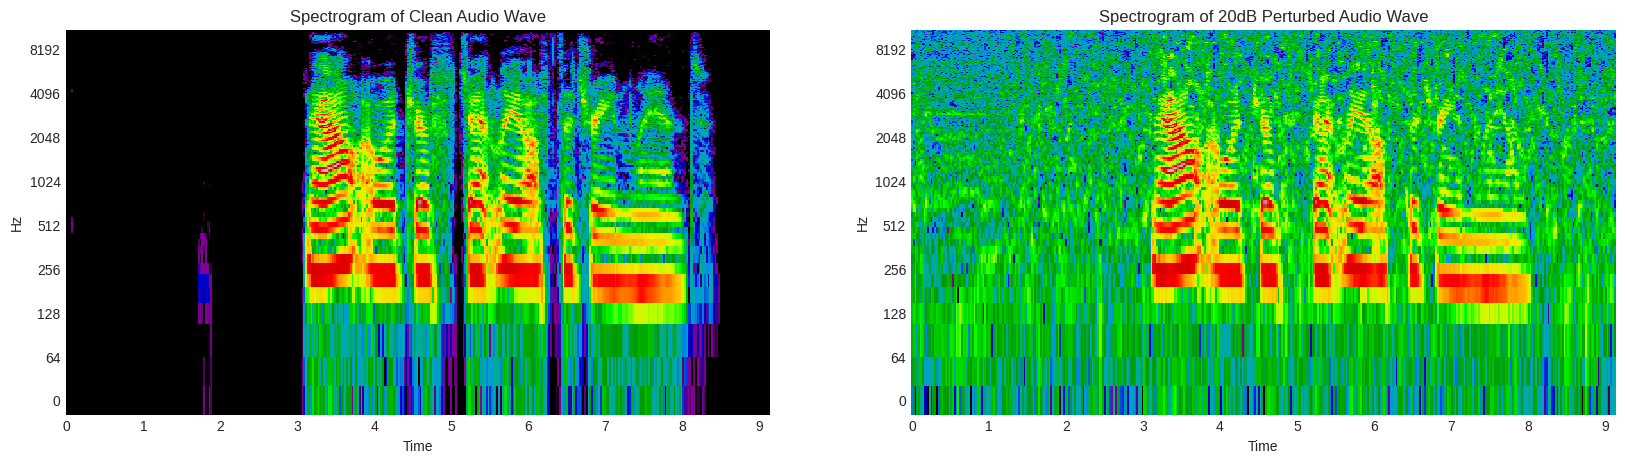

In [22]:
fig, ax =  plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(20,5))
  
librosa.display.specshow(Clean_Data_db, x_axis='time', y_axis='log', ax=ax[0], cmap='nipy_spectral')
ax[0].set_title('Spectrogram of Clean Audio Wave')

librosa.display.specshow(Perturbed_Data_db, x_axis='time', y_axis='log', ax=ax[1], cmap='nipy_spectral')
ax[1].set_title('Spectrogram of 20dB Perturbed Audio Wave');

In [23]:
list_stft.append(CleanSTFT)
list_stft.append(Pert_STFT)
list_zc.append(clean_zc)
list_zc.append(pert_zc)

In [24]:
label = []
label.append(1)
label.append(0)

In [25]:
combineFeatures = []

for stft, zc in zip(list_stft, list_zc):
  flattened_stft = stft.flatten()
  combinedFeature = np.hstack((flattened_stft, zc))
  combineFeatures.append(combinedFeature)

#for loop iterates over two lists (list_stft and list_zc) at the same time.
#In simpler terms, imagine you have two separate lists of items (e.g., a list of fruits and a list of their corresponding prices). 
#This line of code takes the first item from each list, groups them together, and then repeats the process with the second items, 
#the third items, and so on, until it reaches the end of both lists.

In [26]:
df = pd.DataFrame(combineFeatures)
df

,0,1,2,3,4,5,6,7,8,9,...,164224,164225,164226,164227,164228,164229,164230,164231,164232,164233
0,0.000000,0.000002,0.000124,0.000096,0.000113,0.000010,0.000010,0.000013,8.097820e-07,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005083,0.029721,0.000204,0.022716,0.037605,0.016887,0.015883,0.002056,2.052768e-03,0.000343,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [27]:
X = df
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

estimators=20
model = RandomForestClassifier(n_estimators=estimators)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.0

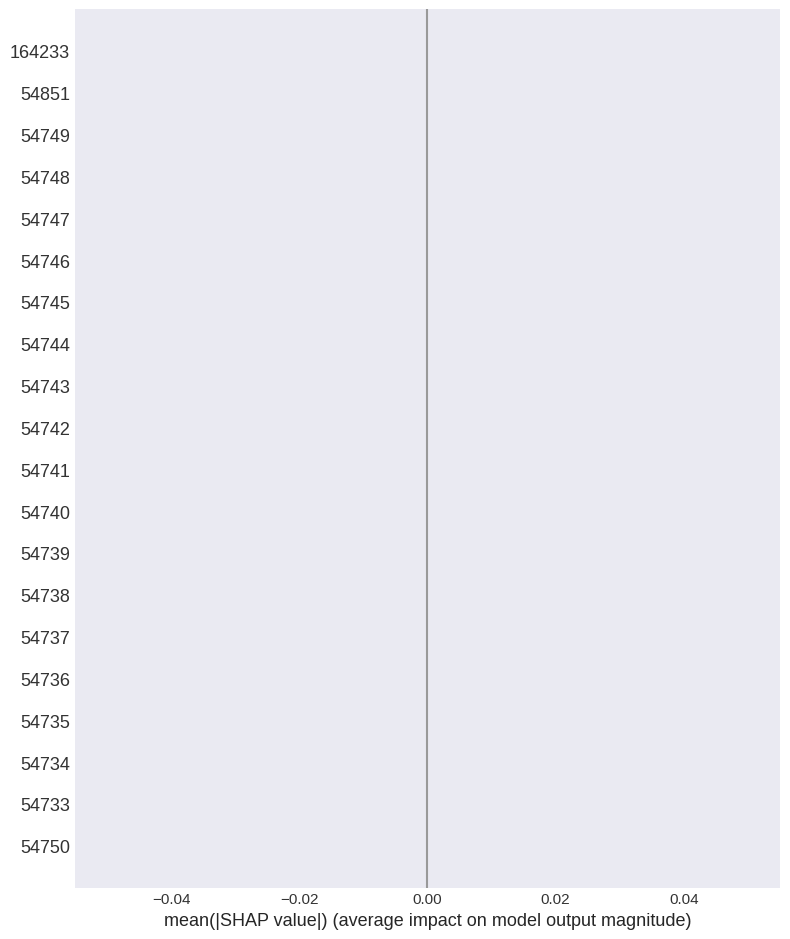

In [28]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")